# Fellowship.ai Challenge
## ULMFiT Sentiment

In [0]:
from fastai.text import *
from pathlib import Path

In [2]:
path = Path("/content")
df = pd.read_csv('https://query.data.world/s/hus7zihvuo5vt65cnv4fcfn2ppfj6y', encoding = "ISO-8859-1")
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,681448150,False,finalized,3,2/25/15 5:24,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/15 11:35,5.703060e+17,NaN,Eastern Time (US & Canada)
1,681448153,False,finalized,3,2/25/15 1:53,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
2,681448156,False,finalized,3,2/25/15 10:01,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2/24/15 11:15,5.703010e+17,Lets Play,Central Time (US & Canada)
3,681448158,False,finalized,3,2/25/15 3:05,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
4,681448159,False,finalized,3,2/25/15 5:50,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2/24/15 11:14,5.703010e+17,NaN,Pacific Time (US & Canada)


In [0]:
data = df[['airline_sentiment', 'text']]
data.to_csv('tweets_sentiment.csv', index=False)

In [4]:
df['text'][1]

"@VirginAmerica plus you've added commercials to the experience... tacky."

Two Stages

Create a LM Model and fine tune the model using the pretrained model

Use the finetune model as classifier

### Language Model

In [0]:
#batch size
bs = 48

# datablock for language model
data_lm = TextLMDataBunch.from_csv(path, 'tweets_sentiment.csv')

In [6]:
data_lm.show_batch()

idx,text
0,! xxmaj looking forward to the future upgrades ! # jetblue http : / / t.co / xxunk xxbos xxmaj reply to @united - xxmaj does n't do any good to check outlets preflight when moved to different equipment after boarding due to malfunction . xxbos @americanair fix the engine of flight xxunk i do n't spend all night in your airport so i can fly home tomorrow xxbos @virginamerica
1,"have been rerouted to match the intended arrival time ( even if you have to incur cost to put us in other airlines ) xxbos @americanair what name and department does it come under ? xxmaj thanks xxbos @usairways any chance u can help our family rebook their flight that was xxmaj cancelled xxmaj flightled , # xxunk ? xxbos @usairways & & @americanair what are your weight restrictions for"
2,xxunk lax .. xxmaj flight to sfo xxbos @united xxmaj do miles earned with xxmaj explorer card count toward lifetime miles ? xxbos @virginamerica xxup lax to xxup ewr - xxmaj middle seat on a red eye . xxmaj such a xxunk maneuver . # xxunk # xxunk xxbos @jetblue xxmaj capital xxmaj one and i explained the false fraud alert . xxmaj why did the xxmaj jet xxmaj blue
3,xxmaj please assist in changing to another flight xxunk 21 xxmaj feb fra to mco xxunk xxup iad . xxbos @americanair xxunk it took them 6 hours to call me back . xxmaj then it disconnected twice . _ xxup ù÷¢ i 'll never get back to work xxbos @united so the last seg of my flight from xxmaj denver ( xxup den ) to hayden / steamboat ( xxup
4,"rude nasty ones you employ . # xxunk xxbos @jetblue hey you guys remembered lol ! xxmaj but now my xxup bos flights delayed ... xxmaj and turn the heat down in xxup t5 it feels hotter than xxup pr . xxbos @jetblue xxmaj have a cup coffee and relax while you check out the xxmaj new xxmaj deals and xxmaj promotions at xxmaj xxunk , twice a month at"


In [0]:
# #Since above step can be a bit time-consuming, it's best to save the result.
# #This will create a 'tmp' directory where all the computed stuff will be stored
# data_lm.save('data_lm_export.pkl')

In [0]:
# # then reload those results using load_data
# data_lm = load_data(path, fname='data_lm_export.pkl')

## Finetune pretrained model 

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on tweets isn't the same as the English of wikipedia, we'll need to adjust the parameters of our model by a little bit. Plus there might be some words that would be extremely common in the reviews dataset but would be barely present in wikipedia, and therefore might not be part of the vocabulary the model was trained on.

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


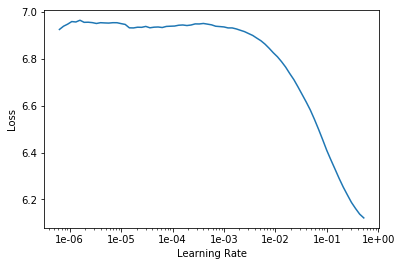

In [10]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [11]:
learn.fit_one_cycle(5, 1.20E-01, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.787531,4.222993,0.231724,00:22
1,4.573230,4.363489,0.225851,00:22
2,4.425691,4.221652,0.238937,00:22
3,4.129050,4.071884,0.255064,00:22
4,3.824923,4.040591,0.259249,00:22


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


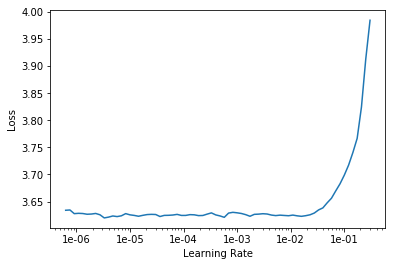

In [12]:
#unfreeze the model and fine-tune it

learn.unfreeze()
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [13]:
learn.fit_one_cycle(10, 6.31E-07, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.631257,4.040823,0.260031,00:27
1,3.624981,4.040573,0.259877,00:27
2,3.634575,4.039784,0.259598,00:27
3,3.627337,4.039253,0.259403,00:27
4,3.621164,4.040434,0.259556,00:27
5,3.626835,4.038859,0.259640,00:27
6,3.630659,4.039129,0.260282,00:27
7,3.624298,4.038867,0.259696,00:27
8,3.618778,4.039281,0.259445,00:28
9,3.625440,4.039282,0.259612,00:27


Let's try to predict what has our language model learned from dataset by letting it generate the sentence .

In [0]:
TEXT = "The worst airline"
N_WORDS = 40
N_SENTENCES = 2

In [15]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

The worst airline concert in order for me to be fully compensated for certain routes at the airport for 2 hours for a flight in Orlando , Flight Booking Problems and hung up on me each time i have
The worst airline . Would have been the worst airline ever xxbos @jetblue Thanks for finding Newark but i have been on hold for over an hour for a two hours . Thank you . xxbos @virginamerica Been


In [0]:
learn.save_encoder('fine_tuned_enc')

## Classifier

In [0]:
# datablock for classifier

data_clas = TextClasDataBunch.from_csv(path, 'tweets_sentiment.csv', vocab=data_lm.train_ds.vocab, bs=32,
                                      text_cols='text', label_cols='airline_sentiment')

In [0]:
# data_clas.save('data_clas.pkl')

In [20]:
data_clas.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup g. xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @united xxunk 7 xxup weeks xxmaj late flightr xxup and i xxup still xxup have xxup not xxup received xxup my xxup miles xxup from xxup the mileageplus xxmaj gift xxmaj card $ 150 xxup xxunk xxup card i xxup handed xxup over ! ! !,negative
"xxbos @americanair my wife was on a flt from xxup bro to xxup tul via xxup dfw that was xxmaj cancelled xxmaj flighted . xxmaj bought an xxup swa flight to get her home . xxmaj xxunk refund , xxup dm me plz ?",negative
"xxbos @usairways i need help . xxmaj in air on # xxunk to xxup clt from xxup phl . xxmaj conf : xxup xxunk xxmaj need confirmed on # 1776 to xxup bna at 10:30 . xxmaj been bumped all day , need home",negative
xxbos @virginamerica xxmaj many xxmaj thanks for the xxmaj follow . \n # ourprincess # freyasfund # xxup usa # xxmaj xxunk \n xxmaj looking for xxmaj any xxunk \n _ xxunk \n _ xxup xxunk http : / / t.co / xxunk,neutral


In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


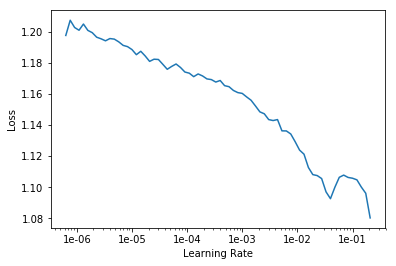

In [22]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [23]:
learn.fit_one_cycle(5, 2.75E-02, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.790323,0.785720,0.667463,00:20
1,0.779146,0.719729,0.718675,00:22
2,0.769110,0.649775,0.747354,00:19
3,0.726724,0.606168,0.753841,00:22
4,0.734863,0.604275,0.751792,00:20


### Gradual Unfreezing

In [24]:
#unfreeze last 1 layer and train
learn.freeze_to(-2)
learn.fit_one_cycle(5, slice(1e-3/(2.6**4), 1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.738169,0.598905,0.756572,00:22
1,0.707947,0.586333,0.761011,00:25
2,0.673733,0.574362,0.767497,00:24
3,0.672034,0.569327,0.775350,00:25
4,0.735628,0.570271,0.765790,00:25


In [25]:
#unfreeze last 2 layers and train
learn.freeze_to(-3)
learn.fit_one_cycle(5, slice(5e-3/(2.6**4), 5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.669618,0.563090,0.773643,00:40
1,0.609244,0.533681,0.782520,00:39
2,0.588513,0.490543,0.800273,00:38
3,0.521119,0.490118,0.803004,00:36
4,0.525113,0.488964,0.803004,00:38


In [0]:
learn.save('3_unfreeze')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


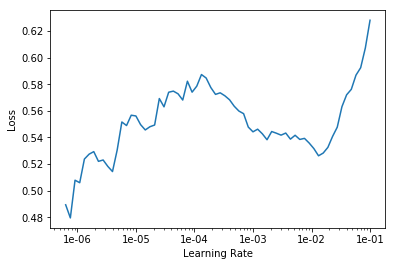

In [27]:
#unfreeze whole model and train
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [28]:
learn.fit_one_cycle(8, slice(1e-4/2*(2.6**4), 1e-4/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.524495,0.483954,0.807101,00:48
1,0.535361,0.483297,0.811540,00:47
2,0.491459,0.469947,0.816661,00:52
3,0.489386,0.476577,0.810174,00:49
4,0.432061,0.462939,0.818027,00:52
5,0.425349,0.459339,0.821099,00:47
6,0.360234,0.462373,0.820417,00:52
7,0.375570,0.459242,0.819734,00:50


## Prediction

In [29]:
learn.predict("The service of Spirt Airways stinks!")

(Category positive, tensor(2), tensor([0.1893, 0.1011, 0.7096]))

In [30]:
learn.predict("Bloody plane is delayed again. An hour delay Sort it out #QANTAS")

(Category negative, tensor(0), tensor([0.9935, 0.0052, 0.0013]))

In [31]:
learn.predict("Woohoo! 4 hour flight delay. I love travel.")

(Category positive, tensor(2), tensor([0.2321, 0.0045, 0.7634]))

In [32]:
learn.predict("The food in this American Airlines flight from Paris is terrible. It's an affront to the destination this plane is coming from!")

(Category negative, tensor(0), tensor([0.8973, 0.0767, 0.0261]))